In [1]:
import numpy as np
import matplotlib.pyplot as plt
import abc
import networkx as nx
from collections import Counter

plt.rcParams["figure.figsize"] = (12,8)
%matplotlib inline

In [2]:
class AbstractUDMIS(abc.ABC):
    @abc.abstractmethod
    def energy(self):
        """Returns the energy of the current Rydberg occupation configuration"""

    @abc.abstractmethod
    def energy_diff(self, *coords):
        """Returns the energy difference resulting from flipping the occupation at the given coordinates"""
        
    @abc.abstractmethod
    def rand_vertex(self):
        """Selects a site in the graph at random"""
    
    def mc_step(self, T):
        """Performs a full update of the Rydberg model using the Metropolis-Hastings algorithm"""
        current_energy = self.energy()
        for _ in range(self.num_vertices):
            vertex = self.rand_vertex()
            dE = self.energy_diff(vertex)
            
            if (dE < 0) or (np.random.rand() < np.exp(-dE / T)):
                current_energy += dE
                self.occupations[vertex] ^= 1 
                # flips occupation 0 --> 1 OR 1 --> 0

        return current_energy

In [3]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)  

In [4]:
u = 2

graph = [(1.19, 4.25), 
         (2.71, 3.48), 
         (1.19, 3.51), 
         (2, 3.38), 
         (1.12, 2.86), 
         (1.70, 2.42),
         (2.36, 2.54),
         (1.52, 1.48),
         (2.15, 1.54),
         (2.14, 1.87),
         (1.72, 0.86),
         (2.29, 0.87)
        ]

udmis = UDMIS(u, graph)

12


In [5]:
N = 10000
t = np.arange(N+1)
T_i = 10000
T_f = 0.001

T = T_i * ((T_f/T_i) ** (t/N))

E_list = []
iterate_max = 0
oc = []

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    
    E_list.append(udmis.mc_step(T=temp))
    v = udmis.occupations.copy()
    oc.append(v)
    
    if t > N*0.1:
        iterate_max = t
        
        if t % 100 == 0:
            #print(t, E_list[t], udmis.occupations)
            pass
    
            if (E_list[t] == E_list[t-1])&(E_list[t-1] == E_list[t-2])&(E_list[t] <= min(E_list)):
                #print(E_list)
                break
                
print(iterate_max)

6300


In [6]:
oc_states = []
for i in oc:
    x = [int(val) for val in i]
    oc_states.append(x)

oc_states_count = map(tuple, oc_states)
final_count = Counter(oc_states_count)

labels, values = zip(*final_count.items())

indexes = np.arange(len(labels))
width = 1

Most common state: [((1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0), 34), ((1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0), 32), ((1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0), 28)]


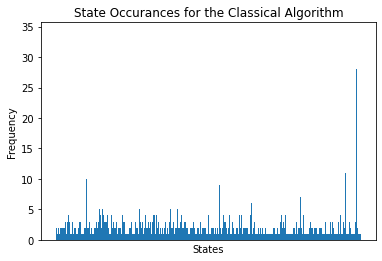

In [7]:
print('Most common state: ' + str(final_count.most_common(3)))

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.title('State Occurances for the Classical Algorithm')
plt.xlabel('States')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.xticks([])
plt.show()

In [8]:
def get_edges(graph):
    Nv = len(graph)
    edges = np.zeros((Nv, Nv))
    for i in range(Nv - 1):
        xi, yi = graph[i]
        for j in range(i + 1, Nv):
            xj, yj = graph[j]
            dij = np.sqrt((xi - xj) ** 2. + (yi - yj) ** 2.)
            if dij < 1:
                edges[i, j] = 1
    return np.argwhere(edges < 1)

In [9]:
edges = get_edges(graph)
G = nx.Graph()
for i in edges:
    for j in edges:
        G.add_edge(i[0], j[1])

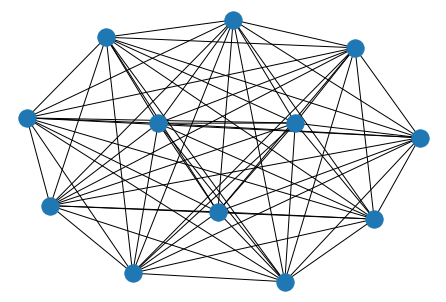

In [10]:
nx.draw(G)

In [11]:
nx.density(G)

1.1818181818181819

In [12]:
graph_algo = [(1.19, 4.25), 
         (2, 3.38), 
         (1.12, 2.86), 
         (2.14, 1.87),
         (2.29, 0.87)
        ]

edges_algo = get_edges(graph_algo)

In [13]:
G2 = nx.Graph()
for i in edges_algo:
    for j in edges_algo:
        G2.add_edge(i[0], j[1])

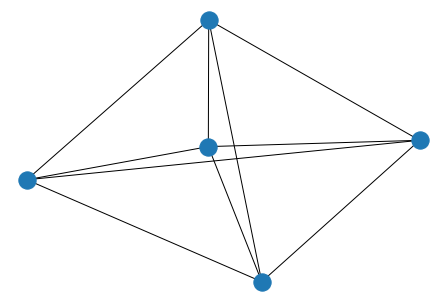

In [14]:
nx.draw(G2)

In [15]:
nx.density(G2)

1.5

In [16]:
service_percentage = 100*((nx.density(G) - nx.density(G2))/nx.density(G2))

In [17]:
service_percentage

-21.212121212121207

In [18]:
#####add a random node#####

In [19]:
graph_algo2 = [(1.19, 4.25), 
         (2, 3.38), 
         (1.12, 2.86),
        (1.70, 2.42),
         (2.14, 1.87),
         (2.29, 0.87)
        ]
edges_algo2 = get_edges(graph_algo2)

G3 = nx.Graph()
for i in edges_algo2:
    for j in edges_algo2:
        G3.add_edge(i[0], j[1])

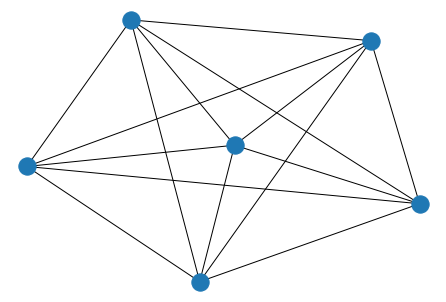

In [20]:
nx.draw(G3)

In [21]:
nx.density(G3)

1.4

In [22]:
service_percentage2 = 100*((nx.density(G) - nx.density(G3))/nx.density(G3))
service_percentage2

-15.584415584415575

In [ ]:
####adding a random node does not change the coverage very much###